# Analyzing the impact of Political and Economic Sentiment on Healthcare and Tech stock market Performance in Election Year 2024

## By: Dennis Goldenberg, Kevin Shao, and Samaa Nadkarni

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, date
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tsa.api import VAR

# Reading in the Data

In [2]:
#trump's odds
trump_odds = pd.read_csv("data/Trump_implied_prob_victory_odds.csv")
trump_odds["DATE"] = trump_odds["Date (UTC)"].apply(lambda x: datetime.strptime(x,
                                                          '%m-%d-%Y 00:00').date())
trump_odds.drop(columns = ["Date (UTC)","Timestamp (UTC)"], inplace = True)
trump_odds.rename({"Price": "trump_odds"}, axis = 1,inplace = True)

#t-bills 2 Year
tbills_2Y = pd.read_csv("data/Tbills_2Y_mkt_yield.csv")
tbills_2Y['DATE'] = tbills_2Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_2Y['DGS2'] = tbills_2Y['DGS2'].astype(float)

#t-bills 10 Year
tbills_10Y = pd.read_csv("data/Tbills_10Y_mkt_yield.csv")
tbills_10Y['DATE'] = tbills_10Y['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#tbills_10Y['DGS10'] = tbills_2Y['DGS10'].astype(float)

#Other Project Data
other_data = pd.read_csv("data/Project Data V1.csv")
other_data["DATE"] = other_data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
other_data.drop(columns = ['date', 'Gold_Price', 'Oil_Price','Gold_Volume',
                           'Oil_Volume'], inplace = True)

#Continue merging procedure
result_Frame = pd.merge(left = pd.merge(left = pd.merge(left = tbills_2Y, 
                                         right = tbills_10Y, 
                                         on = 'DATE'),
                right = trump_odds,
                on = 'DATE'),
         right = other_data,
         on = 'DATE')

In [3]:
columns = np.append(result_Frame.columns.values[-9], 
          np.append(result_Frame.columns.values[-5:-3],
          np.append(result_Frame.columns.values[-8:-5],
                    result_Frame.columns.values[-3:])))
raw_data = result_Frame.copy()[columns]

## Linearly interpolating to fill in missing gaps on market yield Time Series

In [4]:
def interp(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if array_vals[i] == '.':
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

def interp2(dates, array_vals):
    ret_vec = np.empty(shape = (len(array_vals)))
    for i in range(len(array_vals)):
        if ~(array_vals[i] > 0):
            if i == 0:
                delta_0 = (dates[i + 1] - dates[i]).days
                delta_1 = (dates[i + 2] - dates[i + 1]).days
                ret_vec[i] = float(array_vals[i + 1]) - (delta_0/delta_1)(float(array_vals[i + 2]) - float(array_vals[i + 1]))
            elif i == len(array_vals) - 1:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i - 1] - dates[i - 2]).days
                ret_vec[i] = float(array_vals[i - 1]) + (delta_0/delta_1)(float(array_vals[i - 1]) - float(array_vals[i - 2]))
            else:
                delta_0 = (dates[i] - dates[i - 1]).days
                delta_1 = (dates[i + 1] - dates[i - 1]).days
                ret_vec[i] = (delta_0/delta_1)*float(array_vals[i - 1]) + (1 - delta_0/delta_1)*float(array_vals[i + 1])
        else:
            ret_vec[i] = array_vals[i]
    return ret_vec.astype(float)

In [5]:
raw_data['DGS2'] = interp(raw_data['DATE'], raw_data['DGS2'])
raw_data['DGS10'] = interp(raw_data['DATE'], raw_data['DGS10'])
raw_data['BEIR'] = interp2(raw_data['DATE'], raw_data['BEIR'])

In [6]:
raw_data[raw_data.columns.values[1:]].corr()
#Dollar Index and BEIR closely correlated, likely will use BEIR, we will keep this in mind

,NASDAQ 100 Tech Index,S&P Healthcare Index,DGS2,DGS10,trump_odds,Dollar_Index,BEIR,VIX index
NASDAQ 100 Tech Index,1.000000,0.269505,0.113331,0.137348,0.578086,0.189297,0.136811,-0.327581
S&P Healthcare Index,0.269505,1.000000,-0.781413,-0.724043,0.182827,-0.684011,-0.686965,0.402273
DGS2,0.113331,-0.781413,1.000000,0.920299,-0.034817,0.868550,0.758589,-0.541470
DGS10,0.137348,-0.724043,0.920299,1.000000,0.032334,0.902646,0.877826,-0.359944
trump_odds,0.578086,0.182827,-0.034817,0.032334,1.000000,0.179487,0.014218,0.012486
Dollar_Index,0.189297,-0.684011,0.868550,0.902646,0.179487,1.000000,0.729285,-0.316556
BEIR,0.136811,-0.686965,0.758589,0.877826,0.014218,0.729285,1.000000,-0.332449
VIX index,-0.327581,0.402273,-0.541470,-0.359944,0.012486,-0.316556,-0.332449,1.000000


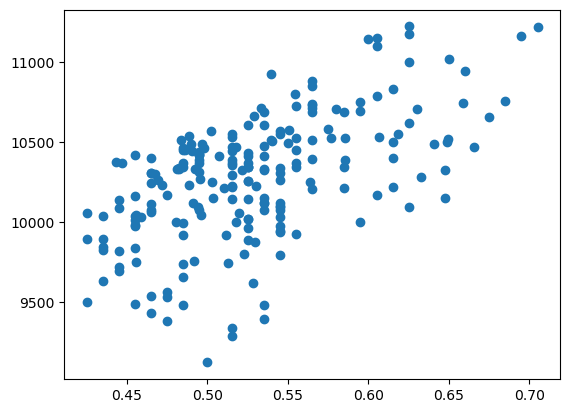

In [7]:
plt.scatter(raw_data['trump_odds'], raw_data['NASDAQ 100 Tech Index'])
plt.show()

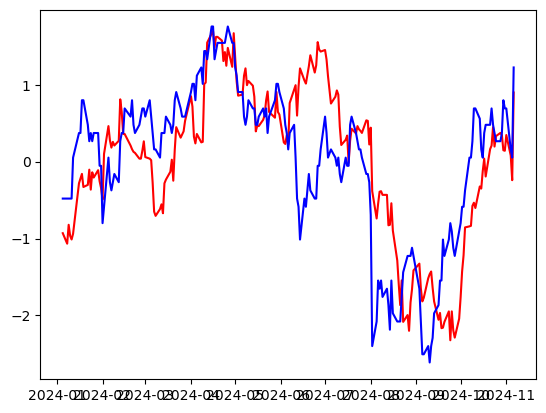

In [8]:
plt.plot(raw_data['DATE'], (raw_data['Dollar_Index'] - np.mean(raw_data['Dollar_Index']))/np.std(raw_data['Dollar_Index']), color = 'red')
plt.plot(raw_data['DATE'], (raw_data['BEIR'] - np.mean(raw_data['BEIR']))/np.std(raw_data['BEIR']), color = 'blue')
plt.show()

# Data Preprocessing

## Examining Stationarity

### Stationarity of Response

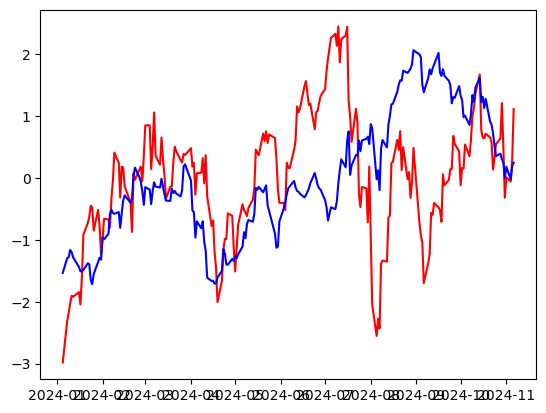

In [9]:
plt.plot(raw_data['DATE'], 
         (raw_data['NASDAQ 100 Tech Index'] - np.mean(raw_data['NASDAQ 100 Tech Index']))/np.std(raw_data['NASDAQ 100 Tech Index']),
          color = 'red')
plt.plot(raw_data['DATE'], 
         (raw_data['S&P Healthcare Index'] - np.mean(raw_data['S&P Healthcare Index']))/np.std(raw_data['S&P Healthcare Index']),
          color = 'blue')
plt.show()

In [10]:
#Stationarity Analysis
test_1 = adfuller(raw_data['NASDAQ 100 Tech Index'])
print(f'ADF Statistic: {test_1[0]}')
print(f'p-value: {test_1[1]}')
for key, value in test_1[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.661804239548556
p-value: 0.004683641110341482
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [11]:
test_2 = adfuller(raw_data['S&P Healthcare Index'])
print(f'ADF Statistic: {test_2[0]}')
print(f'p-value: {test_2[1]}')
for key, value in test_2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.825068981875701
p-value: 0.36808856903609166
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


So, according to the ADF test, the S&P Healthcare index isn't stationary, but the NASDAQ 100 tech index is. I difference the S&P Healthcare Index series and than model again:

In [12]:
differenced_healthcare = raw_data['S&P Healthcare Index'][1:].values - raw_data['S&P Healthcare Index'][0:(len(raw_data['S&P Healthcare Index']) - 1)]
test_3 = adfuller(differenced_healthcare)
print(f'ADF Statistic: {test_3[0]}')
print(f'p-value: {test_3[1]}')
for key, value in test_3[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.494243130073329
p-value: 6.077736548238598e-27
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


In [13]:
differenced_tech = raw_data['NASDAQ 100 Tech Index'][1:].values - raw_data['NASDAQ 100 Tech Index'][0:(len(raw_data['NASDAQ 100 Tech Index']) - 1)]
test_4 = adfuller(differenced_tech)
print(f'ADF Statistic: {test_4[0]}')
print(f'p-value: {test_4[1]}')
for key, value in test_4[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -15.04335026521793
p-value: 9.522285814236921e-28
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


### Stationarity of Covariates

In [14]:
test_5 = adfuller(raw_data['trump_odds'])
print(f'ADF Statistic: {test_5[0]}')
print(f'p-value: {test_5[1]}')
for key, value in test_5[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.1416710698316326
p-value: 0.02361913682441797
Critial Values:
   1%, -3.4633090972761744
Critial Values:
   5%, -2.876029332045744
Critial Values:
   10%, -2.5744932593252643


In [15]:
differenced_trump = raw_data['trump_odds'][1:].values - raw_data['trump_odds'][0:(len(raw_data['trump_odds']) - 1)].values
test_6 = adfuller(differenced_trump)
print(f'ADF Statistic: {test_6[0]}')
print(f'p-value: {test_6[1]}')
for key, value in test_6[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.35965280875008
p-value: 4.1148228518411545e-06
Critial Values:
   1%, -3.4624988216864776
Critial Values:
   5%, -2.8756749365852587
Critial Values:
   10%, -2.5743041549627677


In [16]:
test_7 = adfuller(raw_data['BEIR'])
print(f'ADF Statistic: {test_7[0]}')
print(f'p-value: {test_7[1]}')
for key, value in test_7[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.871810865599115
p-value: 0.3454361203435057
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [17]:
differenced_BEIR = raw_data['BEIR'][1:].values - raw_data['BEIR'][0:(len(raw_data['BEIR']) - 1)].values
test_8 = adfuller(differenced_BEIR)
print(f'ADF Statistic: {test_8[0]}')
print(f'p-value: {test_8[1]}')
for key, value in test_8[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.383281914055713
p-value: 4.929353634536555e-25
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


In [18]:
test_9 = adfuller(raw_data['VIX index'])
print(f'ADF Statistic: {test_9[0]}')
print(f'p-value: {test_9[1]}')
for key, value in test_9[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.7812597527420104
p-value: 0.0031049783628894294
Critial Values:
   1%, -3.46172743446274
Critial Values:
   5%, -2.8753374677799957
Critial Values:
   10%, -2.574124089081557


In [19]:
differenced_VIX = raw_data['VIX index'][1:].values - raw_data['VIX index'][0:(len(raw_data['VIX index']) - 1)].values
test_10 = adfuller(differenced_VIX)
print(f'ADF Statistic: {test_10[0]}')
print(f'p-value: {test_10[1]}')
for key, value in test_10[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -16.437891318333754
p-value: 2.4435037086827278e-29
Critial Values:
   1%, -3.461878735881654
Critial Values:
   5%, -2.875403665910809
Critial Values:
   10%, -2.574159410430839


We do this differencing so that, when doing cross correlation analysis, we actually get real relationships, not relationships of variables with themselves. I difference all variables with a p value less than .05:

In [20]:
result_data = raw_data[['DATE', 'S&P Healthcare Index', 'NASDAQ 100 Tech Index',
                        'trump_odds', 'BEIR', 'VIX index']][1:].copy()
result_data.reset_index(inplace = True, drop = True)
#result_data['NASDAQ 100 Tech Index'] = differenced_tech
#result_data['trump_odds'] = differenced_trump
#result_data['BEIR'] = differenced_BEIR
#result_data['VIX index'] = difference_VIX


#columns_to_standardize = ['S&P Healthcare Index', 'NASDAQ 100 Tech Index', 
#                           'trump_odds', 'BEIR', 'VIX index']
#scaler = StandardScaler()
#result_data[columns_to_standardize] = scaler.fit_transform(result_data[columns_to_standardize])
#result_data.tail()

## Correlelograms of Response

<Figure size 1200x600 with 0 Axes>

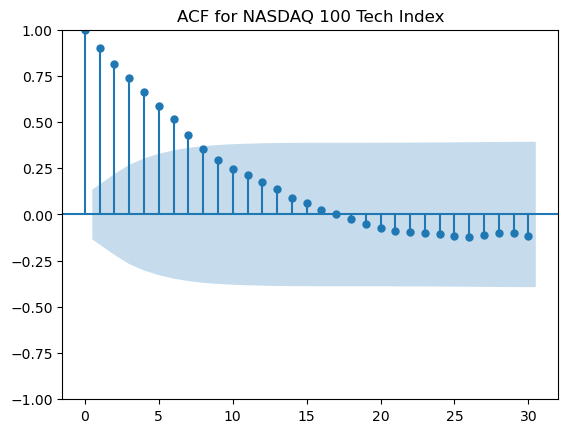

<Figure size 1200x600 with 0 Axes>

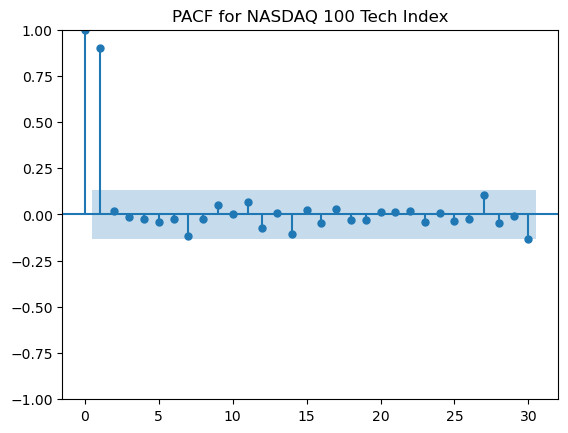

In [21]:
y = result_data['NASDAQ 100 Tech Index']

plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, title="ACF for NASDAQ 100 Tech Index")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, title="PACF for NASDAQ 100 Tech Index")
plt.show()

<Figure size 1200x600 with 0 Axes>

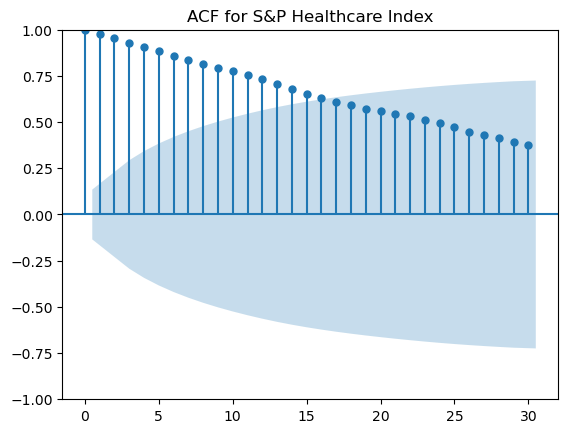

<Figure size 1200x600 with 0 Axes>

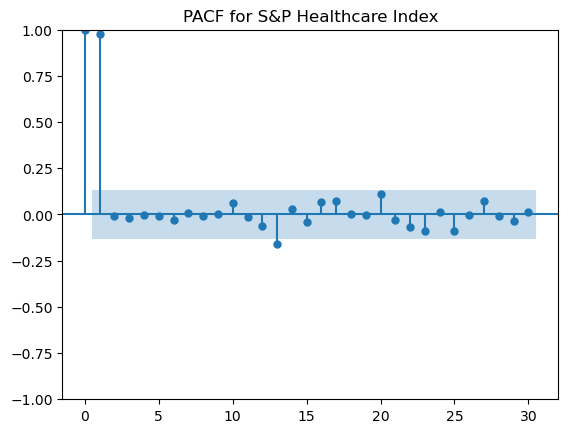

In [22]:
y = result_data['S&P Healthcare Index']

plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, title="ACF for S&P Healthcare Index")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, title="PACF for S&P Healthcare Index")
plt.show()

- Clear evidence of serial correlation

## Cross correlelograms

In [23]:
n_lag = 20

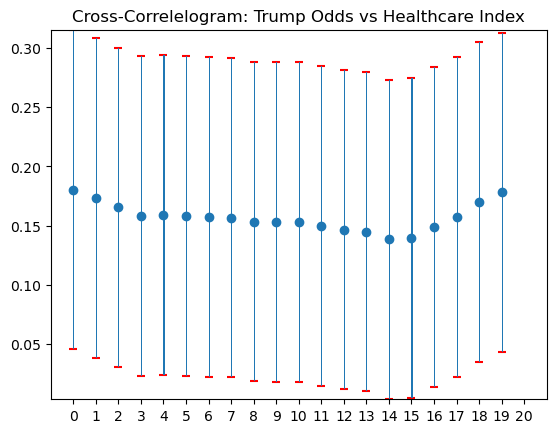

In [24]:
health_trump = ccf(result_data['S&P Healthcare Index'], result_data['trump_odds'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], health_trump[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], health_trump[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], health_trump[1][:,0][0:n_lag], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_trump[1][:,0][0:n_lag])
top_lim = max(health_trump[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_trump[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_trump[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: Trump Odds vs Healthcare Index")
plt.show()

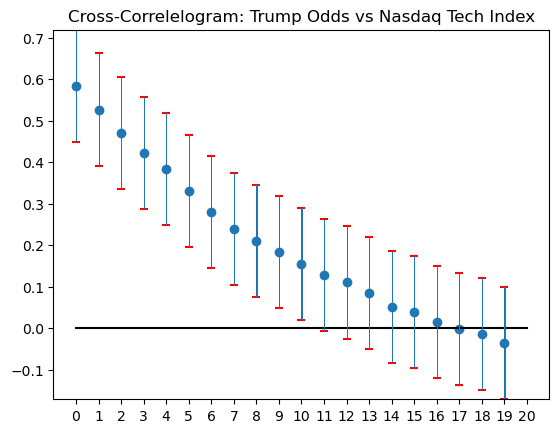

In [25]:
tech_trump = ccf(result_data['NASDAQ 100 Tech Index'], result_data['trump_odds'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], tech_trump[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], tech_trump[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], tech_trump[1][:,0][0:20], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(tech_trump[1][:,0][0:n_lag])
top_lim = max(tech_trump[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_trump[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_trump[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: Trump Odds vs Nasdaq Tech Index")
plt.show()

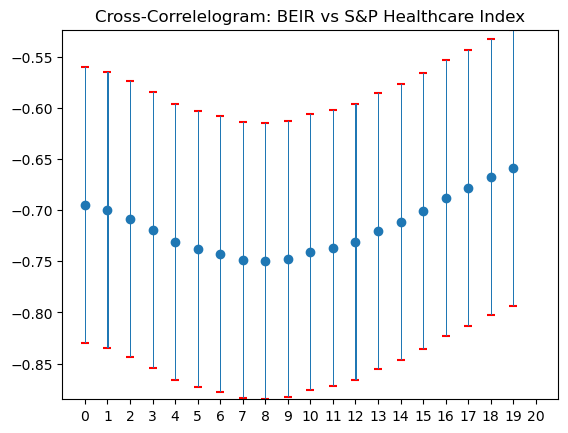

In [26]:
health_BEIR = ccf(result_data['S&P Healthcare Index'], result_data['BEIR'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], health_BEIR[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], health_BEIR[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], health_BEIR[1][:,0][0:n_lag], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_BEIR[1][:,0][0:n_lag])
top_lim = max(health_BEIR[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_BEIR[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_BEIR[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: BEIR vs S&P Healthcare Index")
plt.show()

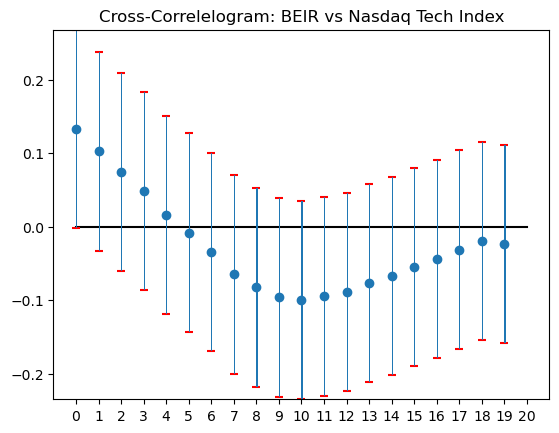

In [27]:
tech_BEIR = ccf(result_data['NASDAQ 100 Tech Index'], result_data['BEIR'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], tech_BEIR[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], tech_BEIR[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], tech_BEIR[1][:,0][0:n_lag], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(tech_BEIR[1][:,0][0:n_lag])
top_lim = max(tech_BEIR[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_BEIR[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_BEIR[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: BEIR vs Nasdaq Tech Index")
plt.show()

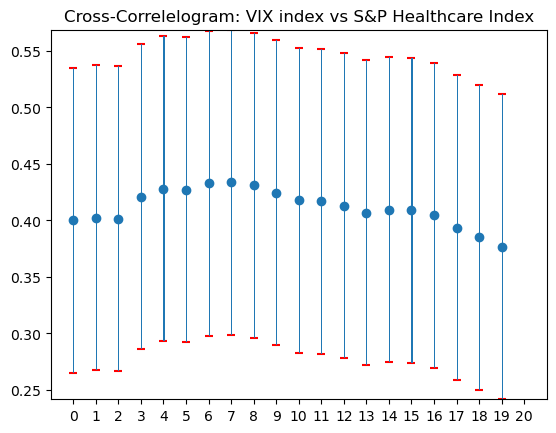

In [28]:
health_VIXIndex = ccf(result_data['S&P Healthcare Index'], result_data['VIX index'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], health_VIXIndex[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], health_VIXIndex[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], health_VIXIndex[1][:,0][0:n_lag], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(health_VIXIndex[1][:,0][0:n_lag])
top_lim = max(health_VIXIndex[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (health_VIXIndex[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (health_VIXIndex[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: VIX index vs S&P Healthcare Index")
plt.show()

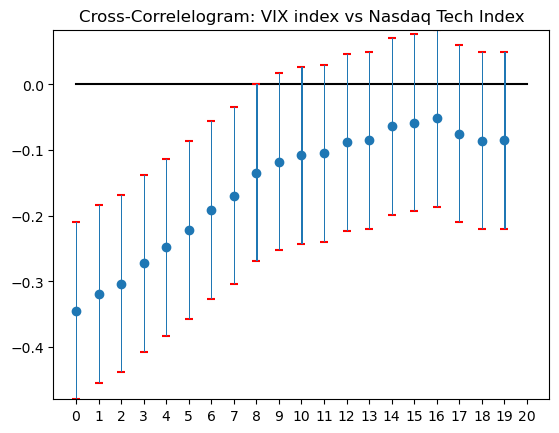

In [29]:
tech_VIXIndex = ccf(result_data['NASDAQ 100 Tech Index'], result_data['VIX index'], adjusted = False, alpha = .05)
fig, ax = plt.subplots()
ax.scatter([i for i in range(0, n_lag)], tech_VIXIndex[0][0:n_lag])
ax.scatter([i for i in range(0,n_lag)], tech_VIXIndex[1][:,1][0:n_lag], marker = '_', color = 'red', zorder = 2)
ax.scatter([i for i in range(0,n_lag)], tech_VIXIndex[1][:,0][0:n_lag], marker = '_', color = 'red', zorder = 2)
bottom_lim = min(tech_VIXIndex[1][:,0][0:n_lag])
top_lim = max(tech_VIXIndex[1][:,1][0:n_lag])
ax.set_ylim(bottom = bottom_lim, top = top_lim)
for i in range(0,n_lag):
    ax.axvspan(xmin = i, xmax = i + .05,
                ymin = (tech_VIXIndex[1][:,0][i] - bottom_lim)/(top_lim - bottom_lim),
                ymax = (tech_VIXIndex[1][:,1][i] - bottom_lim)/(top_lim - bottom_lim),
                  linestyle =  "--",
                  zorder = 2)
ax.plot(np.linspace(0, n_lag), [0] * len(np.linspace(0, n_lag)), color = 'black', zorder = 1)
ax.set_xticks([i for i in range(0, n_lag + 1)])
ax.set_title("Cross-Correlelogram: VIX index vs Nasdaq Tech Index")
plt.show()

The relationships we can glean about the contribution of trump's odds, BEIR, VIX:
- Trump's odds seem to be positively correlated with both Tech Index, as well as healthcare index
-  BEIR: negatively correlated with Tech Index (inflation bad!) and postively correlated with Healthcare Index (recession proof! Or reaction to Trump?)
- VIX: positively correlated with Tech index (volatility means volume up?), negatively correlated with Healthcare (better when volume down?)

# Modeling

## Traditional Time Series Analysis

For Tech Index Based on the ACF and PACF plots:
AR (p): 1 (from the significant spike at lag 1 in the PACF).
MA (q): 1 or 2 (from the gradual decay in the ACF).
Differencing (d): 0 (since the data appears stationary, confirmed if the DF test also suggests stationarity).
Thus, an ARIMA(1, 0, 1) or ARIMA(1, 0, 2) model would be good candidates for testing.


Explanatory Variable	 Lags
VIX index	            Lag 0
BEIR	                Lags 1, 2, 3
Trump odds	            Lags 0, 1, 2

With explanatory variable lags fixed, we first run ARIMA(1,0,2)

### Transforming and Standardizing Data

In [30]:
y = result_data['NASDAQ 100 Tech Index']
#result_data['BEIR_lag1'] = result_data['BEIR'].shift(1)
#result_data['BEIR_lag2'] = result_data['BEIR'].shift(2)
#result_data['BEIR_lag3'] = result_data['BEIR'].shift(3)
#result_data['Trump_odds_lag0'] = result_data['trump_odds']
#result_data['trump_odds_lag1'] = result_data['trump_odds'].shift(1)
#result_data['Trump_odds_lag2'] = result_data['trump_odds'].shift(2)
#result_data['VIX_lag0'] = result_data['VIX index']
#result_data = result_data.dropna()
#trump_odds_lag1 = result_data['trump_odds'].shift(1)
#trump_odds_lag1


In [31]:
y_aligned = result_data['NASDAQ 100 Tech Index']
#X_aligned = result_data[['BEIR_lag1', 'BEIR_lag2', 'BEIR_lag3', 'Trump_odds_lag0', 'Trump_odds_lag1', 'Trump_odds_lag2', 'VIX_lag0']]
X_aligned = result_data[['BEIR', 'VIX index', 'trump_odds']]
#X_aligned = result_data[['BEIR', 'trump_odds']]

scaler = StandardScaler()
train_size = int(len(result_data) * 0.8)
y_train = y_aligned[:train_size]
y_test = y_aligned[train_size:]
X_train = X_aligned[:train_size]
X_test = X_aligned[train_size:]
scaler.fit(X_train)
#Scaled variables
X_train = (X_train - scaler.mean_)/np.sqrt(scaler.var_)
X_test = (X_test - scaler.mean_)/np.sqrt(scaler.var_)
y_train_mean = np.mean(y_train)
y_train_std = np.std(y_train)
y_train = (y_train - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

In [32]:
def arima_output(p, d, q, predictors, response):
    outputs = []
    model = ARIMA(response, order = (p,d,q), exog = predictors)
    model_fit = model.fit()
    outputs.append(model_fit.summary())
    y_test_pred = model_fit.forecast(steps=len(y_test), exog=X_test)
    outputs.append(y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    outputs.append(test_mse)
    outputs.append(model_fit.resid)
    return outputs

### Grid Search to find optimal Time Series differencing variables

In [33]:
max_AR = 2
max_MA = 2

model_sums = np.empty(shape = (max_AR + 1, max_MA + 1))
mse_vals = np.empty(shape = (max_AR + 1, max_MA + 1))
for i in range(0, max_AR + 1):
    for j in range(0, max_MA + 1):
        curr_model = arima_output(i,0,j, X_train, y_train)
        mse_vals[i,j] = curr_model[2]

opt_AR = np.where(mse_vals == np.min(mse_vals))[0][0]
opt_MA = np.where(mse_vals == np.min(mse_vals))[1][0]
print("Optimal p:", opt_AR)
print("Optimal q:", opt_MA)
print("MSE:", round(mse_vals[opt_AR, opt_MA],5))

Optimal p: 0
Optimal q: 2
MSE: 0.68669


### Summary of optimal time series

In [34]:
opt_model_sum, y_test_pred, opt_mse, resid = arima_output(opt_AR, 0, opt_MA, X_train, y_train)

In [35]:
print(opt_model_sum)

                                 SARIMAX Results                                 
Dep. Variable:     NASDAQ 100 Tech Index   No. Observations:                  168
Model:                    ARIMA(0, 0, 2)   Log Likelihood                 -97.183
Date:                   Tue, 03 Dec 2024   AIC                            208.365
Time:                           12:55:04   BIC                            230.233
Sample:                                0   HQIC                           217.240
                                   - 168                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0127      0.077     -0.165      0.869      -0.164       0.138
BEIR           0.0431      0.078      0.553      0.580      -0.110       0.196
VIX index     -0.3315      0

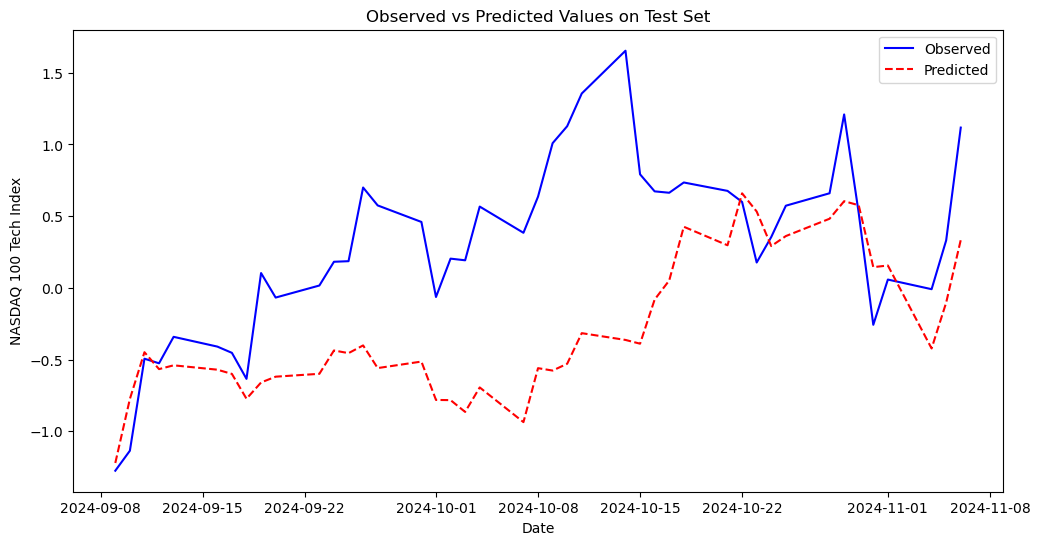

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(result_data['DATE'][train_size:], y_test, label='Observed', color='blue')
plt.plot(result_data['DATE'][train_size:], y_test_pred, 
         label='Predicted', color='red', linestyle='--')
plt.title('Observed vs Predicted Values on Test Set')
plt.xlabel('Date')
plt.ylabel('NASDAQ 100 Tech Index')
plt.legend()
plt.show()

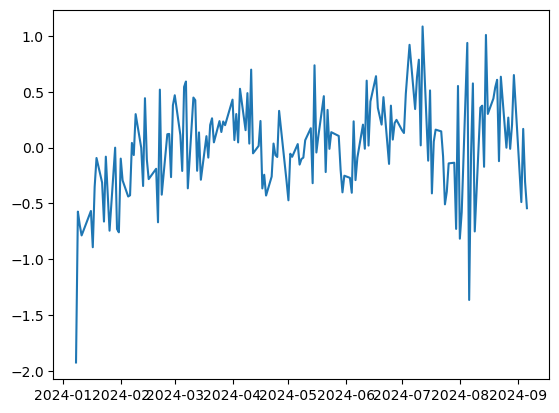

In [37]:
plt.plot(result_data['DATE'][:train_size], resid)
plt.show()

Residual Test to see if we have captured patterns and the remaining is white noise

In [38]:
residuals = resid

ljung_box_results = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

for lag, p_value in zip(ljung_box_results.index, ljung_box_results['lb_pvalue']):
    if p_value > 0.05:
        print(f"At lag {lag}, residuals appear to be white noise.")
    else:
        print(f"At lag {lag}, residuals do not appear to be white noise.")

Ljung-Box Test Results:
       lb_stat     lb_pvalue
10  107.044458  2.101706e-18
15  109.608064  1.917492e-16
20  113.448484  4.597543e-15
At lag 10, residuals do not appear to be white noise.
At lag 15, residuals do not appear to be white noise.
At lag 20, residuals do not appear to be white noise.


### 2. S&p Healthcare Index

In [39]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(y)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Interpret the results
if adf_result[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -3.3886209388614836
p-value: 0.011352953772558629
Critical Values: {'1%': -3.461878735881654, '5%': -2.875403665910809, '10%': -2.574159410430839}
The series is stationary (reject the null hypothesis).


<Figure size 1200x600 with 0 Axes>

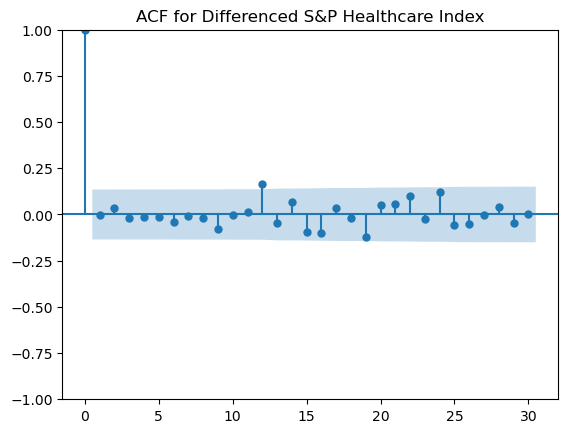

<Figure size 1200x600 with 0 Axes>

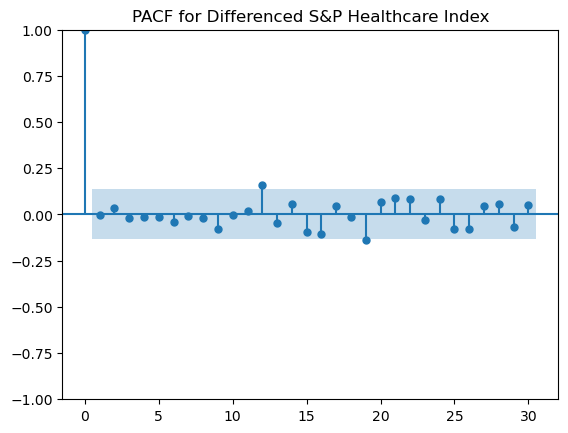

ADF Statistic (Differenced): -14.413673078649598
p-value (Differenced): 8.125825126500466e-27
Critical Values (Differenced): {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
The differenced series is stationary (reject the null hypothesis).


In [40]:
# Apply first differencing
y_diff = result_data['S&P Healthcare Index'].diff().dropna()

plt.figure(figsize=(12, 6))
plot_acf(y_diff, lags=30, title="ACF for Differenced S&P Healthcare Index")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(y_diff, lags=30, title="PACF for Differenced S&P Healthcare Index")
plt.show()

adf_result_diff = adfuller(y_diff)
print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
print("Critical Values (Differenced):", adf_result_diff[4])

if adf_result_diff[1] < 0.05:
    print("The differenced series is stationary (reject the null hypothesis).")
else:
    print("The differenced series is non-stationary (fail to reject the null hypothesis).")


Given the original health Index is not stationary, we here also check the stationarity again for explantory variables for best practice

In [41]:
for col in X_aligned :
    result = adfuller(result_data[col])
    print(f"{col} - p-value: {result[1]}")

    if result[1] < 0.05:
        print(f"{col} is stationary.")
    else:
        print(f"{col} is non-stationary.")


BEIR - p-value: 0.3466269468925512
BEIR is non-stationary.
VIX index - p-value: 0.0030658907062977876
VIX index is stationary.
trump_odds - p-value: 0.026426489378810876
trump_odds is stationary.


In [42]:
#y_diff_aligned = y_diff.loc[X_aligned.index.intersection(y_diff.index)]
#X_aligned = X_aligned.loc[y_diff_aligned.index]
y_aligned = result_data['S&P Healthcare Index']
#X_aligned = result_data[['BEIR_lag1', 'BEIR_lag2', 'BEIR_lag3', 'Trump_odds_lag0', 'Trump_odds_lag1', 'Trump_odds_lag2', 'VIX_lag0']]
X_aligned = result_data[['BEIR', 'Trump_odds_lag0','VIX_lag0']]


KeyError: "['Trump_odds_lag0', 'VIX_lag0'] not in index"

In [ ]:
train_size = int(len(y_aligned) * 0.8)
#y_train = y_diff_aligned[:train_size]
#y_test = y_diff_aligned[train_size:]
y_train = y_aligned[:train_size]
y_test = y_aligned[train_size:]
X_train = X_aligned[:train_size]
X_test = X_aligned[train_size:]

In [ ]:
model = ARIMA(y_train, order=(1, 1, 1), exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     S&P Healthcare Index   No. Observations:                  166
Model:                   ARIMA(1, 1, 1)   Log Likelihood                  57.149
Date:                  Tue, 03 Dec 2024   AIC                           -102.299
Time:                          10:33:41   BIC                            -83.663
Sample:                               0   HQIC                           -94.734
                                  - 166                                         
Covariance Type:                    opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
BEIR               -0.1316      0.047     -2.821      0.005      -0.223      -0.040
Trump_odds_lag0    -0.1109      0.047     -2.360      0.018      -0.203      -0.019
VIX_lag0        

c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
y_test_pred = model_fit.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error (MSE): {test_mse}")

Test Mean Squared Error (MSE): 0.1810064850326265


c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


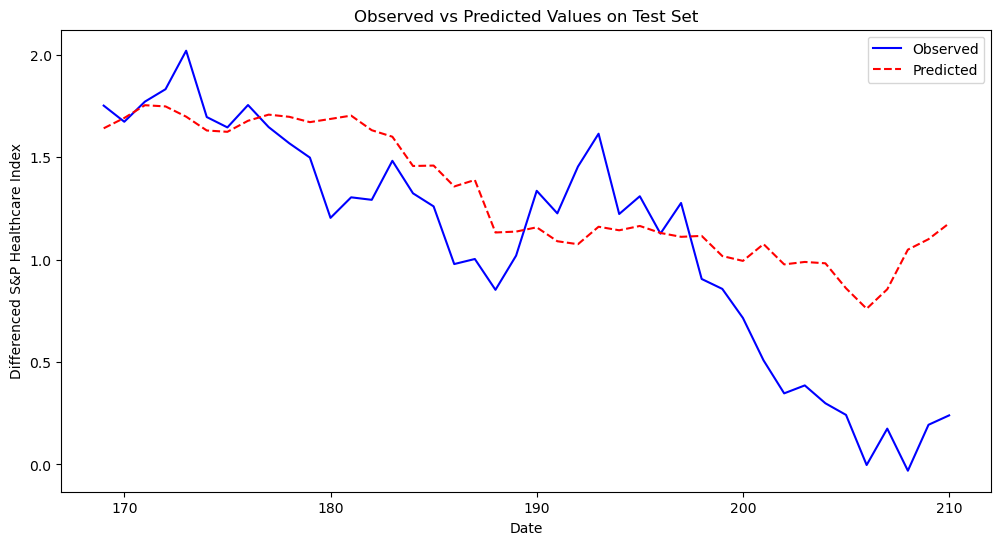

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Observed', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.title('Observed vs Predicted Values on Test Set')
plt.xlabel('Date')
plt.ylabel('Differenced S&P Healthcare Index')
plt.legend()
plt.show()

In [ ]:
residuals = model_fit.resid

ljung_box_results = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

for lag, p_value in zip(ljung_box_results.index, ljung_box_results['lb_pvalue']):
    if p_value > 0.05:
        print(f"At lag {lag}, residuals appear to be white noise.")
    else:
        print(f"At lag {lag}, residuals do not appear to be white noise.")

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  1.163227   0.999657
15  3.069707   0.999536
20  7.143724   0.996186
At lag 10, residuals appear to be white noise.
At lag 15, residuals appear to be white noise.
At lag 20, residuals appear to be white noise.


Let's see how Grid search goes...

In [ ]:
p = range(0, 3)  
d = range(1, 2) 
q = range(0, 3)  
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_params = None
results = []

for params in pdq:
    try:
        model = ARIMA(y_train, order=params, exog=X_train)
        model_fit = model.fit()
        
        # Store AIC
        aic = model_fit.aic
        results.append((params, aic))
        
        # Update best parameters
        if aic < best_aic:
            best_aic = aic
            best_params = params
    except Exception as e:
        continue

results_df = pd.DataFrame(results, columns=["Parameters", "AIC"]).sort_values("AIC")
print(f"Best ARIMA parameters: {best_params}, AIC: {best_aic}")
print(results_df.head())


c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packag

Best ARIMA parameters: (0, 1, 0), AIC: -105.38605858751227
  Parameters         AIC
0  (0, 1, 0) -105.386059
1  (0, 1, 1) -104.216780
3  (1, 1, 0) -104.176383
4  (1, 1, 1) -102.298784
2  (0, 1, 2) -102.284846


c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_model_train = ARIMA(y_train, order=(0, 1, 0), exog=X_train)
best_model_train_fit = best_model_train.fit()

# Print the summary of the trained model
print(best_model_train_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     S&P Healthcare Index   No. Observations:                  166
Model:                   ARIMA(0, 1, 0)   Log Likelihood                  56.693
Date:                  Tue, 03 Dec 2024   AIC                           -105.386
Time:                          10:33:42   BIC                            -92.962
Sample:                               0   HQIC                          -100.343
                                  - 166                                         
Covariance Type:                    opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
BEIR               -0.1486      0.046     -3.248      0.001      -0.238      -0.059
Trump_odds_lag0    -0.0987      0.046     -2.130      0.033      -0.189      -0.008
VIX_lag0        

c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
y_test_pred = best_model_train_fit.forecast(steps=len(y_test), exog=X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error (MSE) for ARIMA(0, 1, 0): {test_mse}")


Test Mean Squared Error (MSE) for ARIMA(0, 1, 0): 0.16963817312800028


c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Dennis Goldenberg\anaconda\envs\ACTU5842env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


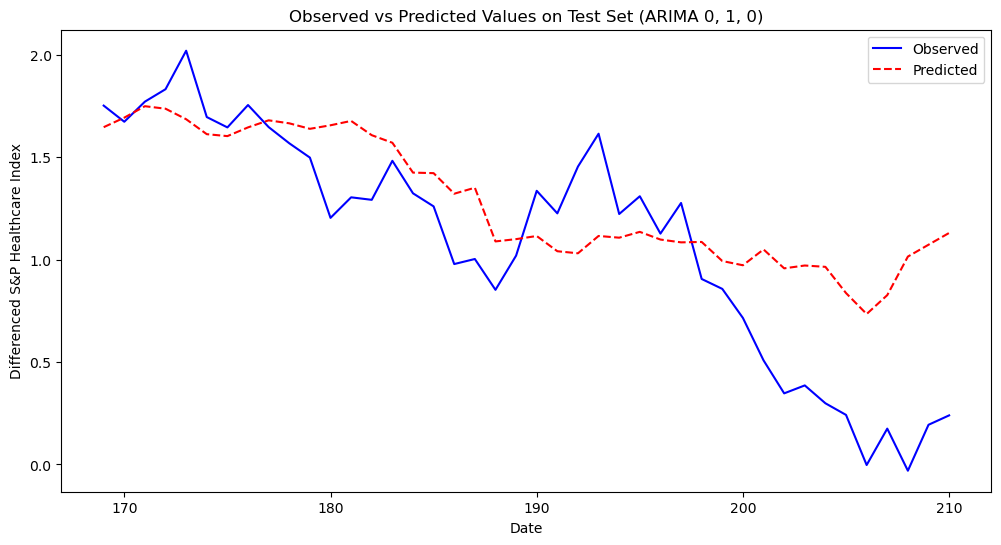

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Observed', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', linestyle='--')
plt.title('Observed vs Predicted Values on Test Set (ARIMA 0, 1, 0)')
plt.xlabel('Date')
plt.ylabel('Differenced S&P Healthcare Index')
plt.legend()
plt.show()

This  ARIMA(0, 1, 0) may not be sufficient.
Differencing Removes Trends, which atagonized our project's goal of predict trend.The d=1 term eliminates the trend by differencing the series. While this makes the series stationary, it removes long-term trends that are crucial for understanding overall market performance in our project. So ARIMA (1, 0, 1) is still the optimal parameters.